# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
%cd /home/jovyan/dea_intertidal/dea-intertidal/

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install sunriset

  Using cached sunriset-1.0-py3-none-any.whl (9.6 kB)


### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map

import rioxarray
import odc.geo.xr

from intertidal.utils import (
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [5]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# # Set study area (e.g. tile ID in form 'x143y87')
# study_area = "x139y96"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

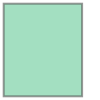

In [6]:
# Set study area name for outputs
study_area = "Sydney"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [7]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43741,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:33369,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/34091/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:43623,


<xarray.Dataset>
Dimensions:      (time: 505, y: 1934, x: 1486)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T23:56:06.568000 ... 2021-12...
  * y            (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06 -3.85e+06
  * x            (x) float64 1.751e+06 1.751e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 1600, 1486), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 15.8 s, sys: 5.94 s, total: 21.7 s
Wall time: 2min 45s


<xarray.Dataset>
Dimensions:      (time: 505, y: 1934, x: 1486)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T23:56:06.568000 ... 2021-12...
  * y            (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06 -3.85e+06
  * x            (x) float64 1.751e+06 1.751e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 -0.4109 -0.3323 -0.3495 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [8]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [9]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2023-11-28 23:21:22 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


2023-11-28 23:22:04 INFO Masking nodata and adding tide heights to satellite data array
2023-11-28 23:22:09 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2023-11-28 23:22:09 INFO Applying valid data mask to constrain study area
2023-11-28 23:23:02 INFO Running per-pixel rolling median


Reducing analysed pixels from 2376677 to 38816 (1.63%)


  0%|          | 0/114 [00:00<?, ?it/s]

2023-11-28 23:23:58 INFO Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 10


2023-11-28 23:23:58 INFO Modelling intertidal uncertainty
2023-11-28 23:24:12,116 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 23:24:12,458 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-28 23:24:12,844 - distributed.utils_perf - WARNING - full garbage collections took 60% CPU time recently (threshold: 10%)
2023-11-28 23:24:13,275 - distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
2023-11-28 23:24:13,753 - distributed.utils_perf - WARNING - full garbage collections took 64% CPU time recently (threshold: 10%)
2023-11-28 23:24:17 INFO Unflattening data back to its original spatial dimensions
2023-11-28 23:24:17 INFO Successfully completed intertidal elevation modelling


### Intertidal extents


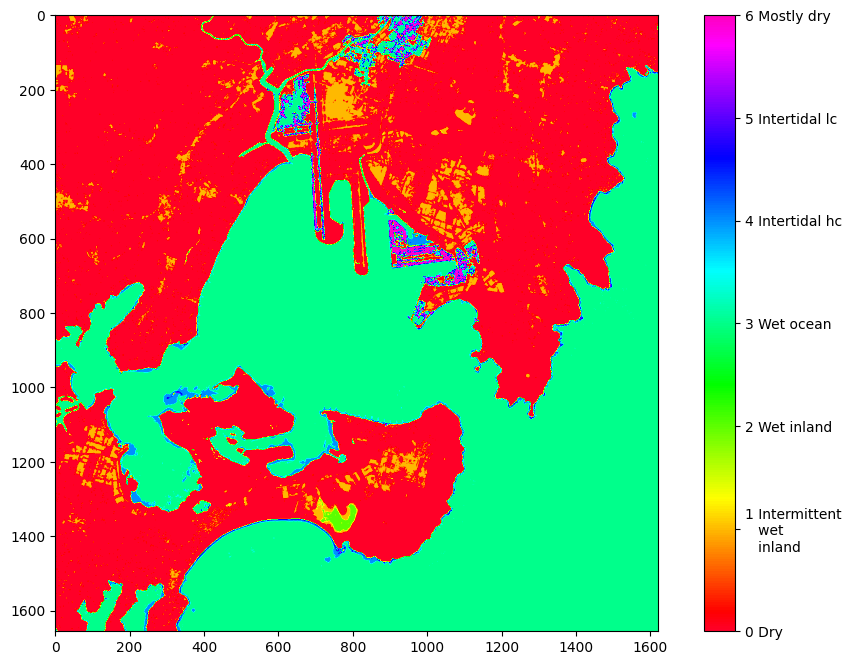

In [10]:
ds['extents'] = extents(freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr)

## Plot
labels=['0 Dry',
       '1 Intermittent\n   wet\n   inland',
       '2 Wet inland',
       '3 Wet ocean',
       '4 Intertidal hc',
       '5 Intertidal lc',
        '6 Mostly dry']

fig,ax=plt.subplots(figsize=(12,8))
cax=ax.imshow(ds['extents'], cmap='gist_rainbow')
cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.show()

In [ ]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)
# Save rasters as GeoTIFFs
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)

In [10]:
# Load data from ABARE's CLUM land-use dataset

def load_reproject(
    path, gbox, name=None, chunks={"x": 2048, "y": 2048}, **reproj_kwargs
):
    """
    Load and reproject part of a raster dataset into a given GeoBox.
    """
    ds = (
        rioxarray.open_rasterio(
            path,
            masked=True,
            chunks=chunks,
        )
        .squeeze("band")
        .odc.reproject(how=gbox, **reproj_kwargs)
    )
    ds.name = name

    return ds

landuse_ds = load_reproject(
    path="/home/jovyan/gdata1/data/land_use/ABARES_CLUM/geotiff_clum_50m1220m/clum_50m1220m.tif",
    # path="/home/jovyan/gdata1/data/land_use/ABARES_CLUM/geotiff_clum_50m1220m/clum_50m1220m_18_class_summary.tif",
    gbox=ds.odc.geobox,
    resampling="nearest",
)

landuse_ds

<xarray.DataArray (y: 1934, x: 1486)>
dask.array<reproject, shape=(1934, 1486), dtype=float32, chunksize=(1934, 1486), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
    spatial_ref  int32 3577
  * y            (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06 -3.85e+06
  * x            (x) float64 1.751e+06 1.751e+06 ... 1.766e+06 1.766e+06
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  11136.69451664353
    STATISTICS_MAXIMUM:      663
    STATISTICS_MEAN:         204.3384927373
    STATISTICS_MINIMUM:      110
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       105.53053831306
    scale_factor:            1.0
    add_offset:              0.0

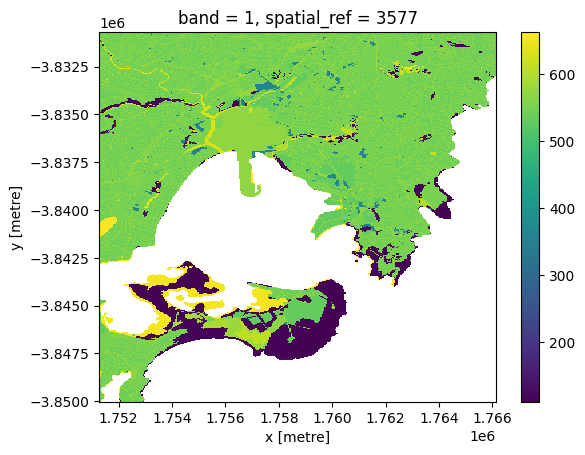

In [11]:
landuse_ds.plot.imshow()

In [12]:
landuse_ds.compute()

<xarray.DataArray (y: 1934, x: 1486)>
array([[572., 572., 572., ..., 553., 553., 553.],
       [572., 572., 572., ..., 553., 553., 553.],
       [572., 572., 572., ..., 553., 553., 553.],
       ...,
       [541., 541., 541., ...,  nan,  nan,  nan],
       [541., 541., 541., ...,  nan,  nan,  nan],
       [541., 541., 541., ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int32 3577
  * y            (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06 -3.85e+06
  * x            (x) float64 1.751e+06 1.751e+06 ... 1.766e+06 1.766e+06
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  11136.69451664353
    STATISTICS_MAXIMUM:      663
    STATISTICS_MEAN:         204.3384927373
    STATISTICS_MINIMUM:      110
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       105.53053831306
    scale_factor:            1.0
    add_offset:              0.0

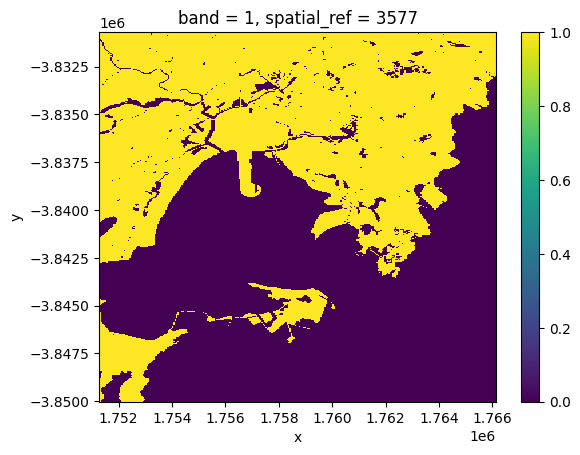

In [98]:
reclassified = xr.where((landuse_ds==500),16,landuse_ds)#Urban intensive uses
reclassified = xr.where((landuse_ds>=530)&(landuse_ds<=538),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=540)&(landuse_ds<=541),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=550)&(landuse_ds<=555),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=560)&(landuse_ds<=567),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=570)&(landuse_ds<=575),16,reclassified)#Urban intensive uses

reclassified = xr.where(reclassified==16,True,False)
reclassified.plot.imshow()

In [121]:
## Master Draft
import xarray as xr
import numpy as np

import datacube
from skimage.measure import label, regionprops
from skimage.morphology import (binary_erosion, disk)

def intertidal_connection(ds, ocean_da, connectivity=1, dilation=None):
    """
    
    Identifies ocean by selecting regions of water that overlap
    with ocean pixels. This region can be optionally dilated to
    ensure that the sub-pixel algorithm has pixels on either side
    of the water index threshold.
    Parameters:
    -----------
    ds : xarray.DataArray
        An array containing True for land pixels, and False for water.
        This can be obtained by thresholding a water index
        array (e.g. MNDWI < 0).
    ocean_da : xarray.DataArray
        A supplementary static dataset used to separate ocean waters
        from other inland water. The array should contain values of 1
        for high certainty ocean pixels, and 0 for all other pixels
        (land, inland water etc). For Australia, we use the  Geodata
        100K coastline dataset, rasterized as the "geodata_coast_100k"
        product on the DEA datacube.
    connectivity : integer, optional
        An integer passed to the 'connectivity' parameter of the
        `skimage.measure.label` function.
    dilation : integer, optional
        The number of pixels to dilate ocean pixels to ensure than
        adequate land pixels are included for subpixel waterline
        extraction. Defaults to None.
    Returns:
    --------
    intertidal_connection : xarray.DataArray
        An array containing the a mask consisting of identified ocean
        pixels as True.
    """

    # First, break all time array into unique, discrete regions/blobs.
    # Fill NaN with 1 so it is treated as a background pixel
    blobs = xr.apply_ufunc(label, ds.fillna(1), 1, False, connectivity)

    # For each unique region/blob, use region properties to determine
    # whether it overlaps with a water feature from `water_mask`. If
    # it does, then it is considered to be directly connected with the
    # ocean; if not, then it is an inland waterbody.
    intertidal_connection = blobs.isin(
        [i.label for i in regionprops(blobs.values, ocean_da.values) if i.max_intensity]
    )

    # Dilate mask so that we include land pixels on the inland side
    # of each shoreline to ensure contour extraction accurately
    # seperates land and water spectra
    if dilation:
        intertidal_connection = xr.apply_ufunc(binary_dilation, intertidal_connection, disk(dilation))

    return intertidal_connection,blobs


def extents(freq,
           dem,
           corr,
           reclassified_clum
           ):
    '''
    Classify coastal ecosystems into broad classes based 
    on their respective patterns of wetting frequency,
    relationship to tidal inundation and proximity to
    intertidal pixels.

    Parameters:
    -----------
    dem : xarray.DataArray
        An xarray.DataArray of the final intertidal DEM, generated 
        during the intertidal.elevation workflow
    freq : xarray.DataArray
        An xarray.DataArray of the NDWI frequency layer summarising the 
        frequency of wetness per pixel for any given time-series, 
        generated during the intertidal.elevation workflow
    corr : xarray.DataArray
        An xarray.DataArray of the correlation between pixel NDWI values
        and the tide-height, generated during the intertidal.elevation workflow

    Returns:
    --------
    extents: xarray.DataArray
        A binary xarray.DataArray depicting intertidal (0), tidal-wet (1),
        nontidal-wet (2), intermittently, non-tidal wet (3) and dry (4) coastal extents.
    Notes:
    ------
    Classes are defined as follows:
    '''
    # 0: Dry
    #     Pixels with wettness `freq` < 0.05
    #     Includes intermittently dry pixels with wetness frequency < 0.5 and > 0.05
    #     and `corr` to tide > 0.1 to capture intertidal pixels buffered
    #     out by the `corr` threshold of 0.2
    # 1: Intertidal
    #     Frequency of pixel wetness (`freq`) is > 0.01 and < 0.99
    #     The correlation (`corr`) between `freq` and tide-heights is > 0.2
    # 2: Wet tidal
    #     Frequency of pixel wetness (`freq`) is > 0.95
    #     Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
    #     and `corr` to tide > 0.1. This captures intertidal pixels buffered
    #     out by the `corr` threshold of 0.2 (default)
    #     Pixels are located offshore, within 10 pixels of known ocean, as defined
    #     by the Geodata 100k coastline dataset (`ocean_da`)
    # 3: Wet nontidal
    #     Frequency of pixel wetness (`freq`) is > 0.95
    #     Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
    #     and `corr` to tide > 0.1. This captures intertidal pixels buffered
    #     out by the `corr` threshold of 0.2 (default)
    #     Pixels are located onshore, more than 10 pixels from known ocean, as defined
    #     by the Geodata 100k coastline dataset (`ocean_da`)
    # 4: Intermittently wet nontidal
    #     Pixels with wetting `freq` between 0.95 and 0.05 and
    #     `corr` of `freq` to tide is < 0.1    
    
    ## Connect to datacube to load `ocean_da`
    dc = datacube.Datacube(app='ocean_masking')
 
    ## Set the upper and lower freq thresholds
    upper, lower = 0.99, 0.01
    
    '''--------------------------------------------------------------------'''
    ## Identify broad classes based on wetness frequency and tidal correlation
    dry = freq.where((freq < lower), drop=True)
    intermittent = freq.where((freq>=lower)&(freq<=upper),np.nan)
    wet = freq.where((freq>upper),np.nan)

    ##### Separate intermittent_tidal (intertidal)
    intertidal = freq.where(
                        (freq==intermittent)
                        &(corr>=0.15),
                        drop=True
                        )

    ##### Separate intermittent_nontidal
    intermittent_nontidal = freq.where(
                        (freq==intermittent)
                        &(corr<0.15),
                        drop=False
                        )
        
    ##### Separate high and low confidence intertidal pixels
    intertidal_hc = intertidal.where(dem.notnull(),drop=True)
    intertidal_lc = intertidal.where(dem.isnull(),drop=True)
    '''--------------------------------------------------------------------'''
    ##### Classify 'wet' pixels based on connectivity to intertidal pixels (into 'wet_ocean' and 'wet_inland')

    ## Create the 'always wet + intertidal' ds to compare against 'intertidal' pixels
    ## only for intertidal connectivity
    wet_intertidal = xr.where(freq>=lower,0,1)

    ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
    if freq.isnull().any()==True is True:
        wet_intertidal = wet_intertidal.where(freq.notnull(), 0)

    ## Create a true/false layer of intertidal pixels (1) vs everything else (0)
    # # Extract intertidal pixels (value 1) then erode these by 1 pixels to ensure we only
    # # use high certainty intertidal regions for identifying connectivity to wet
    # # pixels in our satellite imagery.
    inter = freq.where((freq>=lower)&
                          (freq<=upper)&
                          (corr>=0.15))
    ## Convert to true/false
    inter = xr.where(freq==inter,True,False)
    ## Drop Nans
    if freq.isnull().any()==True is True:
        inter = inter.where(freq.notnull(), drop=True)
    ## Erode outer edge pixels by 1 pixel to drop extrema intertidal pixels and ensure connection 
    ## to high certainty intertidal pixels (POSSIBLY UNNECCESARY due to corr definition of intertidal pixels)
    inter = xr.apply_ufunc(binary_erosion, inter == 1, disk(1))

    ## Applying intertidal_connection masking function for the first of two times
    ## This first mask identifies where wet+intertidal pixels connect to intertidal pixels
    intertidal_mask1,_ = intertidal_connection(wet_intertidal, inter, connectivity=1)
    
    ## Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
    # intertidal_maskx = xr.where(reclassified.where(intertidal_mask1==True),False,True, keep_attrs=True)

    ## Prepare data to test for wet pixel connection to the connected 'wet and intertidal' mask.
    ## Identify and relabel the pixels in 'freq' that are 'wet (0)' and 'other (1)'.
    wet_bool = xr.where(freq==wet,False,True)
    ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
    if freq.isnull().any()==True is True:
        wet_bool = wet_bool.where(freq.notnull(), 0)

    ## Applying intertidal_connection masking function for the second time
    intertidal_mask2,_ = intertidal_connection(wet_bool, intertidal_mask1, connectivity=1)
    
    ## Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
    intertidal_mask2 = xr.where(reclassified.where(intertidal_mask2==True),False,True, keep_attrs=True)    

    # ## distinguish wet inland class from wet ocean class
    wet_inland = wet_bool.where((wet_bool==0) & (intertidal_mask2 == False))#, drop=True) ## Weird artefacts when drop=True
    wet_ocean = wet_bool.where((wet_bool==0) & (intertidal_mask2 == True), drop=True)

    '''--------------------------------------------------------------------'''
    ## Classify 'intermittently wet' pixels into 'intermittently_wet_inland' and 'other-intertidal_fringe'
    ## Identify and relabel the pixels in 'freq' that are 'intermittent_nontidal wet (0)' and 'other (1)'.
    int_nt = xr.where(freq==intermittent_nontidal,False,True)
    ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
    if freq.isnull().any()==True is True:
        int_nt = int_nt.where(freq.notnull(), 0)

    ## Applying intertidal_connection masking function to separate inland from intertidal connected pixels
    intertidal_mask,_ = intertidal_connection(int_nt, intertidal_mask1, connectivity=1)
    
    ## Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
    intertidal_mask = xr.where(reclassified.where(intertidal_mask==True),False,True, keep_attrs=True)

    # ## distinguish intermittent inland from intermittent-other (intertidal_fringe) pixels
    intermittent_inland = int_nt.where((int_nt==0) & (intertidal_mask == False))#, drop=True) ## Weird artefacts when drop=True
    intertidal_fringe = int_nt.where((int_nt==0) & (intertidal_mask == True), drop=True)
    
    ## Isolate mostly dry pixels from intertidal_fringe class
    mostly_dry = intertidal_fringe.where(freq < 0.1, drop=True)
    ## Isolate mostly wet pixels from intertidal fringe class
    mostly_wet = intertidal_fringe.where(freq >= 0.1, drop=True)
    '''--------------------------------------------------------------------'''
    ## Combine wet_ocean and intertidal_fringe pixels
    wet_ocean = wet_ocean.combine_first(mostly_wet)
    
    ## Relabel pixels
    dry = dry.where(dry.isnull(), 0)
    wet_ocean = wet_ocean.where(wet_ocean.isnull(),3)
    wet_inland = wet_inland.where(wet_inland.isnull(),2)
    intermittent_inland = intermittent_inland.where(intermittent_inland.isnull(),1)
    intertidal_hc = intertidal_hc.where(intertidal_hc.isnull(),4)
    intertidal_lc = intertidal_lc.where(intertidal_lc.isnull(),5)
    # Add intertidal_fringe pixels to wet_ocean class
    # intertidal_fringe = intertidal_fringe.where(intertidal_fringe.isnull(),6)
    mostly_dry = mostly_dry.where(mostly_dry.isnull(),6)
    

    ## Combine
    extents = dry.combine_first(wet_ocean)
    extents = extents.combine_first(wet_inland)
    extents = extents.combine_first(intertidal_hc)
    extents = extents.combine_first(intermittent_inland)
    # extents = extents.combine_first(intertidal_fringe)
    extents = extents.combine_first(intertidal_lc)
    extents = extents.combine_first(mostly_dry)

    
    
    return extents,intertidal_mask2,intertidal_mask,intermittent_inland

In [118]:
# import gc
# gc.collect()

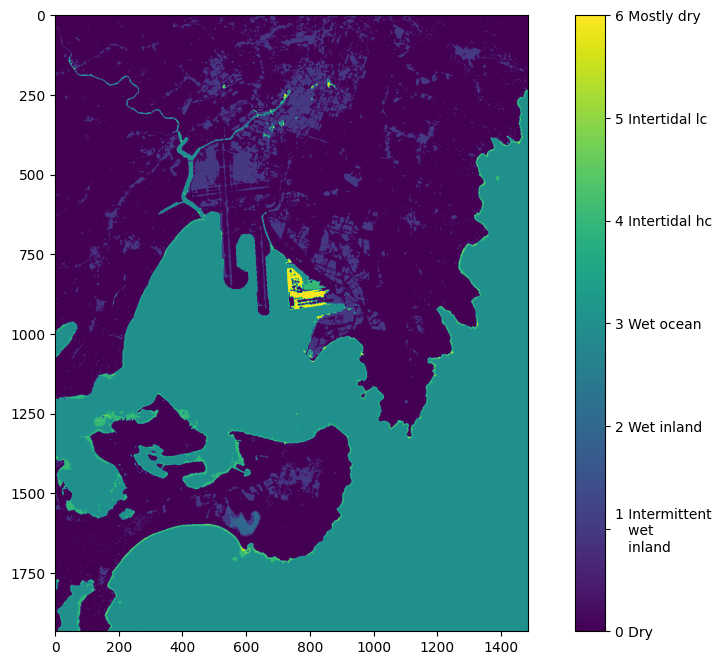

In [122]:
ds['extents'],intertidal_mask2,intertidal_mask,intermittent_inland = extents(freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr, reclassified_clum=reclassified)

## Plot
labels=['0 Dry',
       '1 Intermittent\n   wet\n   inland',
       '2 Wet inland',
       '3 Wet ocean',
       '4 Intertidal hc',
       '5 Intertidal lc',
       '6 Mostly dry'
       ]

fig,ax=plt.subplots(figsize=(12,8))
cax=ax.imshow(ds['extents'])
cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.show()

In [125]:
intermittent_inland.load()

<xarray.DataArray 'ndwi_wet_freq' (y: 1934, x: 1486)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06 -3.85e+06
  * x            (x) float64 1.751e+06 1.751e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 3577
    band         int64 1

In [133]:
### Working code
## Todo: try Robbi's odc.geo.xr masking code to erode 'intensive_urban' class by 1 pixel

urban_dry = reclassified.where((reclassified==True)&(intermittent_inland.notnull()))#,False,True))#, keep_attrs=True))
i_inland_new = intermittent_inland.where(urban_dry.isnull())

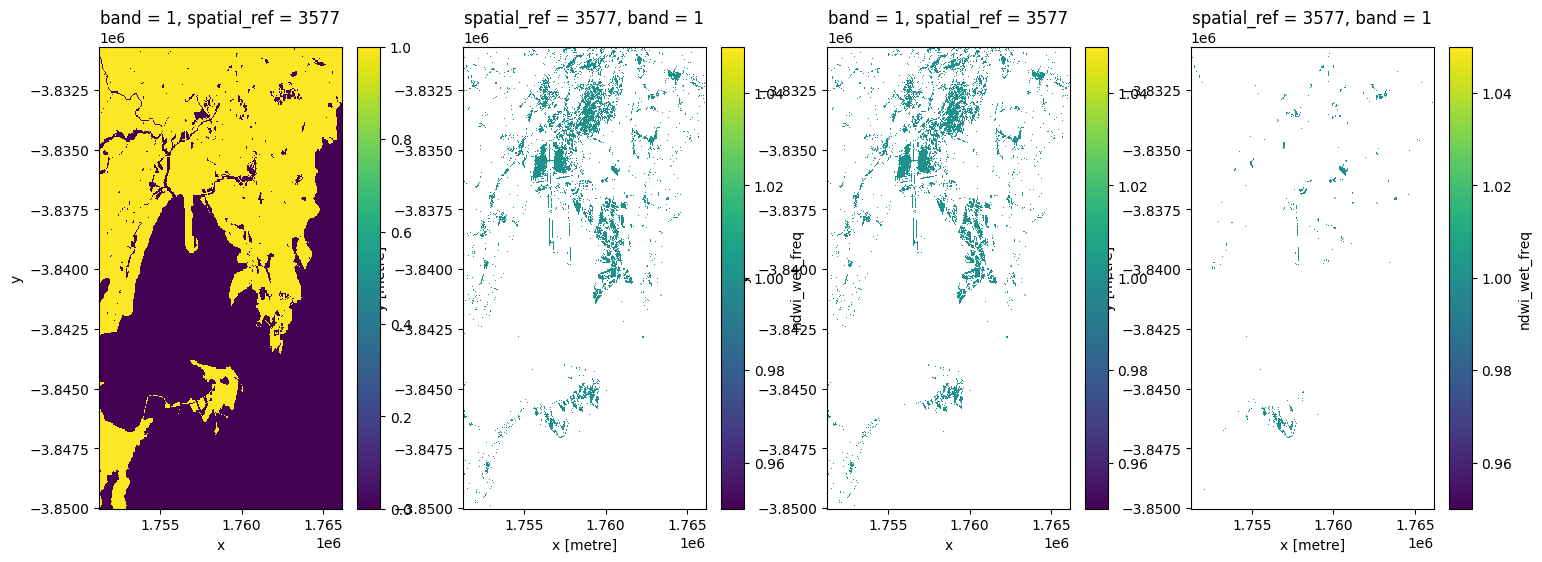

In [135]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(18,6))
reclassified.plot.imshow(ax=ax0)
intermittent_inland.plot.imshow(ax=ax1)
urban_dry.plot.imshow(ax=ax2)
i_inland_new.plot.imshow(ax=ax3)

In [49]:
# # xr.where(intertidal_mask1.where(reclassified==True,drop=True),True,False).plot.imshow()
# xr.where(reclassified.where(intertidal_mask1==True),False,True).plot.imshow()


In [47]:
intertidal_mask1.load()

# from datacube.utils.cog import write_cog
# intertidal_mask1.attrs=satellite_ds.attrs
intertidal_maskx = intertidal_mask1.to_dataset(name='intertidal_maskx')

# intertidal_mask1.load()
# intertidal_mask1=intertidal_mask1*1
# intertidal_maskx['intertidal_maskx'].plot.imshow()
# write_cog(geo_im = intertidal_mask1,
#            fname='/data/interim/testing/intertidal_mask1.tif',
#            overwrite=True)

intertidal_maskx=intertidal_maskx*1

# import rioxarray
# ## Output as COG 
# intertidal_mask1.rio.to_raster(raster_path=f"{output_dir}/{study_area}_{start_date}_{end_date}.tif",
#                            driver='COG')
# intertidal_mask1 = intertidal_mask1.drop_vars('band')
intertidal_maskx = intertidal_maskx[['y','x','intertidal_maskx']]

In [62]:
# reclassified.load()
reclass = reclassified.to_dataset(name='reclassified')
reclass = reclass*1
reclass = reclass[['y','x','reclassified']]

In [63]:
# intertidal_maskx.load()
reclass

<xarray.Dataset>
Dimensions:       (y: 1934, x: 1486)
Coordinates:
  * y             (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06 -3.85e+06
  * x             (x) float64 1.751e+06 1.751e+06 ... 1.766e+06 1.766e+06
    band          int64 1
    spatial_ref   int32 3577
Data variables:
    reclassified  (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0

In [53]:
print(ds)
print(ds_aux)
print(intertidal_maskx)

<xarray.Dataset>
Dimensions:                (y: 1934, x: 1486)
Coordinates:
  * y                      (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06
  * x                      (x) float64 1.751e+06 1.751e+06 ... 1.766e+06
    spatial_ref            int32 3577
Data variables:
    elevation              (y, x) float64 nan nan nan nan ... nan nan nan nan
    elevation_uncertainty  (y, x) float64 nan nan nan nan ... nan nan nan nan
    extents                (y, x) float64 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0
<xarray.Dataset>
Dimensions:                  (y: 1934, x: 1486)
Coordinates:
  * y                        (y) float64 -3.831e+06 -3.831e+06 ... -3.85e+06
  * x                        (x) float64 1.751e+06 1.751e+06 ... 1.766e+06
    spatial_ref              int32 3577
Data variables:
    intertidal_candidate_px  (y, x) float64 nan nan nan nan ... nan nan nan nan
    misclassified_px_count   (y, x) float64 nan nan nan nan ... nan nan nan nan
    ndwi_tide_corr           (y, x) float6

In [67]:
reclass.attrs = satellite_ds.attrs

In [68]:
reclass.attrs

{'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'}

In [69]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)
# Save rasters as GeoTIFFs
# export_intertidal_rasters(
#     ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
# )
# export_intertidal_rasters(
#     ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
# )
export_intertidal_rasters(
    reclass, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)

CRSError: The WKT could not be parsed. OGR Error code 5

In [129]:
study_area = 'testing'

In [ ]:
# ## Testing reworked wetness freq thresholds. Not Master Draft
# import xarray as xr
# import numpy as np

# import datacube
# from skimage.measure import label, regionprops
# from skimage.morphology import (binary_erosion, disk)

# def intertidal_connection(ds, ocean_da, connectivity=1, dilation=None):
#     """
    
#     Identifies ocean by selecting regions of water that overlap
#     with ocean pixels. This region can be optionally dilated to
#     ensure that the sub-pixel algorithm has pixels on either side
#     of the water index threshold.
#     Parameters:
#     -----------
#     ds : xarray.DataArray
#         An array containing True for land pixels, and False for water.
#         This can be obtained by thresholding a water index
#         array (e.g. MNDWI < 0).
#     ocean_da : xarray.DataArray
#         A supplementary static dataset used to separate ocean waters
#         from other inland water. The array should contain values of 1
#         for high certainty ocean pixels, and 0 for all other pixels
#         (land, inland water etc). For Australia, we use the  Geodata
#         100K coastline dataset, rasterized as the "geodata_coast_100k"
#         product on the DEA datacube.
#     connectivity : integer, optional
#         An integer passed to the 'connectivity' parameter of the
#         `skimage.measure.label` function.
#     dilation : integer, optional
#         The number of pixels to dilate ocean pixels to ensure than
#         adequate land pixels are included for subpixel waterline
#         extraction. Defaults to None.
#     Returns:
#     --------
#     intertidal_connection : xarray.DataArray
#         An array containing the a mask consisting of identified ocean
#         pixels as True.
#     """

#     # First, break all time array into unique, discrete regions/blobs.
#     # Fill NaN with 1 so it is treated as a background pixel
#     blobs = xr.apply_ufunc(label, ds.fillna(1), 1, False, connectivity)

#     # For each unique region/blob, use region properties to determine
#     # whether it overlaps with a water feature from `water_mask`. If
#     # it does, then it is considered to be directly connected with the
#     # ocean; if not, then it is an inland waterbody.
#     intertidal_connection = blobs.isin(
#         [i.label for i in regionprops(blobs.values, ocean_da.values) if i.max_intensity]
#     )

#     # Dilate mask so that we include land pixels on the inland side
#     # of each shoreline to ensure contour extraction accurately
#     # seperates land and water spectra
#     if dilation:
#         intertidal_connection = xr.apply_ufunc(binary_dilation, intertidal_connection, disk(dilation))

#     return intertidal_connection


# def extents(freq,
#            dem,
#            corr,
#            ):
#     '''
#     Classify coastal ecosystems into broad classes based 
#     on their respective patterns of wetting frequency,
#     relationship to tidal inundation and proximity to
#     intertidal pixels.

#     Parameters:
#     -----------
#     dem : xarray.DataArray
#         An xarray.DataArray of the final intertidal DEM, generated 
#         during the intertidal.elevation workflow
#     freq : xarray.DataArray
#         An xarray.DataArray of the NDWI frequency layer summarising the 
#         frequency of wetness per pixel for any given time-series, 
#         generated during the intertidal.elevation workflow
#     corr : xarray.DataArray
#         An xarray.DataArray of the correlation between pixel NDWI values
#         and the tide-height, generated during the intertidal.elevation workflow

#     Returns:
#     --------
#     extents: xarray.DataArray
#         A binary xarray.DataArray depicting intertidal (0), tidal-wet (1),
#         nontidal-wet (2), intermittently, non-tidal wet (3) and dry (4) coastal extents.
#     Notes:
#     ------
#     Classes are defined as follows:
#     '''
#     # 0: Dry
#     #     Pixels with wettness `freq` < 0.05
#     #     Includes intermittently dry pixels with wetness frequency < 0.5 and > 0.05
#     #     and `corr` to tide > 0.1 to capture intertidal pixels buffered
#     #     out by the `corr` threshold of 0.2
#     # 1: Intertidal
#     #     Frequency of pixel wetness (`freq`) is > 0.01 and < 0.99
#     #     The correlation (`corr`) between `freq` and tide-heights is > 0.2
#     # 2: Wet tidal
#     #     Frequency of pixel wetness (`freq`) is > 0.95
#     #     Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
#     #     and `corr` to tide > 0.1. This captures intertidal pixels buffered
#     #     out by the `corr` threshold of 0.2 (default)
#     #     Pixels are located offshore, within 10 pixels of known ocean, as defined
#     #     by the Geodata 100k coastline dataset (`ocean_da`)
#     # 3: Wet nontidal
#     #     Frequency of pixel wetness (`freq`) is > 0.95
#     #     Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
#     #     and `corr` to tide > 0.1. This captures intertidal pixels buffered
#     #     out by the `corr` threshold of 0.2 (default)
#     #     Pixels are located onshore, more than 10 pixels from known ocean, as defined
#     #     by the Geodata 100k coastline dataset (`ocean_da`)
#     # 4: Intermittently wet nontidal
#     #     Pixels with wetting `freq` between 0.95 and 0.05 and
#     #     `corr` of `freq` to tide is < 0.1    
    
#     ## Connect to datacube to load `ocean_da`
#     dc = datacube.Datacube(app='ocean_masking')
 
#     ## Set the upper and lower freq thresholds
#     upper, lower = 0.99, 0.01
    
#     '''--------------------------------------------------------------------'''
#     ## Identify broad classes based on wetness frequency and tidal correlation
#     dry = freq.where((freq < lower), drop=True)
#     intermittent = freq.where((freq>=lower)&(freq<=upper),np.nan)
#     wet = freq.where((freq>upper),np.nan)

#     ##### Separate intermittent_tidal (intertidal)
#     intertidal = freq.where(
#                         (freq==intermittent)
#                         &(corr>=0.15),
#                         drop=True
#                         )

#     ##### Separate intermittent_nontidal
#     intermittent_nontidal = freq.where(
#                         (freq==intermittent)
#                         &(corr<0.15),
#                         drop=False
#                         )
            
#     ##### Separate high and low confidence intertidal pixels
#     intertidal_hc = intertidal.where(dem.notnull(),drop=True)
#     intertidal_lc = intertidal.where(dem.isnull(),drop=True)
#     '''--------------------------------------------------------------------'''
#     ##### Classify 'wet' pixels based on connectivity to intertidal pixels (into 'wet_ocean' and 'wet_inland')

#     ## Create the 'always wet + intertidal' ds to compare against 'intertidal' pixels
#     ## only for intertidal connectivity
#     wet_intertidal = xr.where(freq>=lower,0,1)

#     ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
#     if freq.isnull().any()==True is True:
#         wet_intertidal = wet_intertidal.where(freq.notnull(), 0)

#     ## Create a true/false layer of intertidal pixels (1) vs everything else (0)
#     # # Extract intertidal pixels (value 1) then erode these by 1 pixels to ensure we only
#     # # use high certainty intertidal regions for identifying connectivity to wet
#     # # pixels in our satellite imagery.
#     inter = freq.where((freq>=lower)&
#                           (freq<=upper)&
#                           (corr>=0.15))
#     ## Convert to true/false
#     inter = xr.where(freq==inter,True,False)
#     ## Drop Nans
#     if freq.isnull().any()==True is True:
#         inter = inter.where(freq.notnull(), drop=True)
#     ## Erode outer edge pixels by 1 pixel to drop extrema intertidal pixels and ensure connection 
#     ## to high certainty intertidal pixels (POSSIBLY UNNECCESARY due to corr definition of intertidal pixels)
#     inter = xr.apply_ufunc(binary_erosion, inter == 1, disk(1))

#     ## Applying intertidal_connection masking function for the first of two times
#     ## This first mask identifies where wet+intertidal pixels connect to intertidal pixels
#     intertidal_mask1 = intertidal_connection(wet_intertidal, inter, connectivity=1)

#     ## Prepare data to test for wet pixel connection to the connected 'wet and intertidal' mask.
#     ## Identify and relabel the pixels in 'freq' that are 'wet (0)' and 'other (1)'.
#     wet_bool = xr.where(freq==wet,False,True)
#     ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
#     if freq.isnull().any()==True is True:
#         wet_bool = wet_bool.where(freq.notnull(), 0)

#     ## Applying intertidal_connection masking function for the second time
#     intertidal_mask2 = intertidal_connection(wet_bool, intertidal_mask1, connectivity=1)

#     # ## distinguish wet inland class from wet ocean class
#     wet_inland = wet_bool.where((wet_bool==0) & (intertidal_mask2 == False))#, drop=True) ## Weird artefacts when drop=True
#     wet_ocean = wet_bool.where((wet_bool==0) & (intertidal_mask2 == True), drop=True)

#     '''--------------------------------------------------------------------'''
#         ## Separate dry and wetter fractions of intertmittent nontidal
#     # intermittent_nontidal_wet = xr.where(intermittent_nontidal.where(freq>=0.05),0,1)
#     intermittent_nontidal_wet = intermittent_nontidal.where(freq>=0.1)
    
#     ## Classify 'intermittently wet' pixels into 'intermittently_wet_inland' and 'other-intertidal_fringe'
#     ## Identify and relabel the pixels in 'freq' that are 'intermittent_nontidal wet (0)' and 'other (1)'.
#     int_nt_wet = xr.where(freq==intermittent_nontidal_wet,False,True)
#     ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
#     if freq.isnull().any()==True is True:
#         int_nt_wet = int_nt_wet.where(freq.notnull(), 0)

#     ## Applying intertidal_connection masking function to separate inland from intertidal connected pixels
#     intertidal_mask_wet = intertidal_connection(int_nt_wet, intertidal_mask1, connectivity=1)

#     # ## distinguish intermittent inland from intermittent-other (intertidal_fringe) pixels
#     intermittent_inland_wet = int_nt_wet.where((int_nt_wet==0) & (intertidal_mask_wet == False))#, drop=True) ## Weird artefacts when drop=True
#     intertidal_fringe_wet = int_nt_wet.where((int_nt_wet==0) & (intertidal_mask_wet == True), drop=True)
    
#     # ## Isolate mostly dry pixels from intertidal_fringe class
#     # mostly_dry_w = intertidal_fringe_wet.where(freq < 0.05, drop=True)
#     # ## Isolate mostly wet pixels from intertidal fringe class
#     # mostly_wet_w = intertidal_fringe_wet.where(freq >= 0.05, drop=True)
    
#     '''--------------------------------------------------------------------'''  
#             ## Separate dry and wetter fractions of intertmittent nontidal
#     # intermittent_nontidal_dry = xr.where(intermittent_nontidal.where(freq<0.05),0,1)
#     intermittent_nontidal_dry = intermittent_nontidal.where(freq<0.1)
    
#     ## Classify 'intermittently dry' pixels into 'intermittently_dry_inland' and 'other'
#     int_nt_dry = xr.where(freq==intermittent_nontidal_dry,False,True)
#     ## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
#     if freq.isnull().any()==True is True:
#         int_nt_dry = int_nt_dry.where(freq.notnull(), 0)

#     ## Applying intertidal_connection masking function to separate inland from intertidal connected pixels
#     intertidal_mask_dry = intertidal_connection(int_nt_dry, intertidal_mask1, connectivity=1)

#     # ## distinguish intermittent inland from intermittent-other (intertidal_fringe) pixels
#     intermittent_inland_dry = int_nt_dry.where((int_nt_dry==0) & (intertidal_mask_dry == False))#, drop=True) ## Weird artefacts when drop=True
#     intertidal_fringe_dry = int_nt_dry.where((int_nt_dry==0) & (intertidal_mask_dry == True), drop=True)
    
#     # ## Isolate mostly dry pixels from intertidal_fringe class
#     # mostly_dry = intertidal_fringe.where(freq < 0.05, drop=True)
#     # ## Isolate mostly wet pixels from intertidal fringe class
#     # mostly_wet = intertidal_fringe.where(freq >= 0.05, drop=True)    
    

#     '''--------------------------------------------------------------------'''
#     ## Combine wet_ocean and intertidal_fringe pixels
#     wet_ocean = wet_ocean.combine_first(intertidal_fringe_wet)
    
#     ## Relabel pixels
#     dry = dry.where(dry.isnull(), 0)
#     wet_ocean = wet_ocean.where(wet_ocean.isnull(),3)
#     wet_inland = wet_inland.where(wet_inland.isnull(),2)
#     intermittent_inland = intermittent_inland_wet.where(intermittent_inland_wet.isnull(),1)
#     intertidal_hc = intertidal_hc.where(intertidal_hc.isnull(),4)
#     intertidal_lc = intertidal_lc.where(intertidal_lc.isnull(),5)
#     # Add intertidal_fringe pixels to wet_ocean class
#     # intertidal_fringe = intertidal_fringe.where(intertidal_fringe.isnull(),6)
#     mostly_dry = intermittent_inland_dry.where(intermittent_inland_dry.isnull(),6)
#     intertidal_fringe_dry = intertidal_fringe_dry.where(intertidal_fringe_dry.isnull(),7)

#     ## Combine
#     extents = dry.combine_first(wet_ocean)
#     extents = extents.combine_first(wet_inland)
#     extents = extents.combine_first(intertidal_hc)
#     extents = extents.combine_first(intermittent_inland)
#     # extents = extents.combine_first(intertidal_fringe)
#     extents = extents.combine_first(intertidal_lc)
#     extents = extents.combine_first(mostly_dry)
#     extents = extents.combine_first(intertidal_fringe_dry)

    
    
#     return extents, intermittent_nontidal,freq

In [ ]:
# ds['extents'], intermittent_nontidal,freq = extents(freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr)

# ## Plot
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal hc',
#        '5 Intertidal lc',
#        '6 Mostly dry',
#        '7 Intertidal\n    fringe\n    dry'
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'])
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5,6,7])
# cbar.ax.set_yticklabels(labels)
# plt.show()

In [ ]:
# intermittent_nontidal.plot()
ds['extents'].plot.hist()

In [ ]:
# intermittent_nontidal_wet = xr.where(intermittent_nontidal.where(freq>=0.05),False,True)
intermittent_nontidal_wet = intermittent_nontidal.where(freq>=0.1)
intermittent_nontidal_wet.plot()

In [ ]:
# ### freq=ds_aux.ndwi_wet_freq
# corr=ds_aux.ndwi_tide_corr
# dem =ds.elevation

# upper, lower = 0.99, 0.01

# ## Identify broad classes based on wetness frequency and tidal correlation
# dry = freq.where((freq < lower), drop=True)
# intermittent = freq.where((freq>=lower)&(freq<=upper),np.nan)
# wet = freq.where((freq>upper),np.nan)

# ##### Separate intermittent_tidal (intertidal)
# intertidal = freq.where(
#                     (freq==intermittent)
#                     &(corr>=0.15),
#                     drop=True
#                     )

# ##### Separate intermittent_nontidal
# intermittent_nontidal = freq.where(
#                     (freq==intermittent)
#                     &(corr<0.15),
#                     drop=False
#                     )

# fig, axes = plt.subplots(3,3,figsize=(9,9))

# dem.plot(ax=axes[0][0])
# axes[0][0].set_title('dem')
# freq.plot(ax=axes[0][1])
# axes[0][1].set_title('freq')
# corr.plot(ax=axes[0][2])
# axes[0][2].set_title('corr')

# dry.plot(ax=axes[1][0])
# axes[1][0].set_title('dry')
# intermittent.plot(ax=axes[1][1])
# axes[1][1].set_title('intermittent')
# wet.plot(ax=axes[1][2])
# axes[1][2].set_title('wet')

# intertidal.plot(ax=axes[2][0])
# axes[2][0].set_title('intertidal')
# intermittent_nontidal.plot(ax=axes[2][1])
# axes[2][1].set_title('intermittent\nnontidal')

# plt.setp(axes, xticks=[], yticks=[], xlabel='', ylabel='')

# fig.tight_layout()

In [ ]:
# fig, (ax1,ax2) = plt.subplots(1,2)
# intertidal.where(dem.notnull()).plot(ax=ax1)
# intertidal.where(dem.isnull()).plot(ax=ax2)

In [ ]:
# ds_aux.ndwi_wet_freq.where(ds.extents==5).plot()

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
(
    ds["oa_lat"],
    ds["oa_hat"],
    ds["oa_lot"],
    ds["oa_hot"],
    ds["oa_spread"],
    ds["oa_offset_lowtide"],
    ds["oa_offset_hightide"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq, extents=ds.extents, lot_hot=True, lat_hat=True
)

### Tideline confidence

In [ ]:
(hightideline, lowtideline, tidelines_gdf) = tidal_offset_tidelines(
    extents=ds.extents,
    offset_hightide=ds.oa_offset_hightide,
    offset_lowtide=ds.oa_offset_lowtide,
    distance=250,
)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["L"],
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["M"],
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug"
)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson"
)
lowtideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson"
)
tidelines_gdf.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson"
)

### Close Dask client

In [ ]:
client.close()